<a href="https://colab.research.google.com/github/AY1895/loan-approval-prediction/blob/main/Loan_approval_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
file_path = "/content/loan.xlsx"
loan_data = pd.read_excel(file_path)

In [ ]:
# Check the first few rows and structure of the dataset
print(loan_data.head())
print(loan_data.info())

     LoanID Gender Married  Dependents     Education SelfEmployed  \
0  LP001002   Male      No         0.0      Graduate           No   
1  LP001003   Male     Yes         1.0      Graduate           No   
2  LP001005   Male     Yes         0.0      Graduate          Yes   
3  LP001006   Male     Yes         0.0  Not Graduate           No   
4  LP001008   Male      No         0.0      Graduate           No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  LoanAmountTerm  \
0             5849                0.0         0.0           360.0   
1             4583             1508.0       128.0           360.0   
2             3000                0.0        66.0           360.0   
3             2583             2358.0       120.0           360.0   
4             6000                0.0       141.0           360.0   

   CreditHistory PropertyArea  LoanStatus  
0            1.0        Urban           1  
1            1.0        Rural           0  
2            1.0        Urban         

In [ ]:
# Check for missing values
print(loan_data.isnull().sum())

LoanID                0
Gender               13
Married               3
Dependents           15
Education             0
SelfEmployed         32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           21
LoanAmountTerm       14
CreditHistory        50
PropertyArea          0
LoanStatus            0
dtype: int64


In [ ]:
 # Handle missing values
loan_data = loan_data.dropna()

In [ ]:
# Check if the dataset is empty after removing missing values
if loan_data.empty:
    raise ValueError("All rows have missing values and were removed. Check your data.")


In [ ]:
# Convert categorical variables to numeric using Label Encoding
categorical_columns = ['Gender', 'Married', 'Education', 'SelfEmployed', 'PropertyArea', 'LoanStatus']
label_encoders = {}

for column in categorical_columns:
    if column in loan_data.columns:
        le = LabelEncoder()
        loan_data[column] = le.fit_transform(loan_data[column])
        label_encoders[column] = le
    else:
        raise ValueError(f"Column {column} not found in the dataset. Check your data.")


In [ ]:
# Ensure LoanStatus is a factor for classification
loan_data['LoanStatus'] = loan_data['LoanStatus'].astype('category')

In [ ]:
# Feature Engineering (Add any additional features if applicable)
# Example: loan_data['Income_to_Loan_Ratio'] = loan_data['Income'] / loan_data['LoanAmount']

In [ ]:
# Split the data into training and testing sets
X = loan_data.drop('LoanStatus', axis=1)
y = loan_data['LoanStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
# Split the data into training and testing sets
X = loan_data.drop(['LoanStatus', 'LoanID'], axis=1)  # Drop LoanID as it's not a useful feature
y = loan_data['LoanStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the XGBClassifier model
xgb_model = XGBClassifier(use_label_encoder=False)

# Define a smaller hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],  # Reduced number of estimators
    'learning_rate': [0.1],     # Fewer learning rates
    'max_depth': [3, 6],        # Reduced max depth
    'gamma': [0, 0.1],          # Fewer gamma values
    'colsample_bytree': [0.7],  # Reduced colsample_bytree
    'min_child_weight': [1, 5]  # Reduced min_child_weight
}

# Set up GridSearchCV with the updated parameter grid
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=5, verbose=1)  # Reduced cv to 5 for faster results

# Fit the model to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [ ]:
# Predict on the test set
xgb_predictions = best_xgb_model.predict(X_test_scaled)
xgb_proba = best_xgb_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Confusion matrix for XGBoost
confusion_matrix_xgb = confusion_matrix(y_test, xgb_predictions)
print("Confusion Matrix for XGBoost:")
print(confusion_matrix_xgb)

Confusion Matrix for XGBoost:
[[14 18]
 [ 2 63]]


In [ ]:
# Train a logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)
logistic_predictions_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]
logistic_predictions_class = (logistic_predictions_proba > 0.5).astype(int)

In [ ]:
# Confusion matrix for Logistic Regression
confusion_matrix_logistic = confusion_matrix(y_test, logistic_predictions_class)
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix_logistic)

Confusion Matrix for Logistic Regression:
[[13 19]
 [ 2 63]]


In [ ]:
# Train a decision tree model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_scaled, y_train)
tree_predictions = tree_model.predict(X_test_scaled)


In [ ]:
# Confusion matrix for Decision Tree
confusion_matrix_tree = confusion_matrix(y_test, tree_predictions)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix_tree)

Confusion Matrix for Decision Tree:
[[19 13]
 [14 51]]


In [ ]:
# Train an SVM model
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, y_train)
svm_predictions_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
svm_predictions_class = svm_model.predict(X_test_scaled)

In [ ]:
# Confusion matrix for SVM
confusion_matrix_svm = confusion_matrix(y_test, svm_predictions_class)
print("Confusion Matrix for SVM:")
print(confusion_matrix_svm)

Confusion Matrix for SVM:
[[13 19]
 [ 2 63]]


In [ ]:
# k-NN Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_predictions = knn_model.predict(X_test_scaled)

# Confusion matrix for k-NN
confusion_matrix_knn = confusion_matrix(y_test, knn_predictions)
print("Confusion Matrix for k-NN:")
print(confusion_matrix_knn)

Confusion Matrix for k-NN:
[[14 18]
 [ 4 61]]


In [ ]:
# Collect performance metrics
models = {
    'XGBoost': xgb_proba,
    'Logistic Regression': logistic_predictions_proba,
    'Decision Tree': tree_predictions,
    'SVM': svm_predictions_proba,
    'k-NN': knn_predictions
}

NameError: name 'xgb_proba' is not defined

XGBoost AUC: 0.7774
Logistic Regression AUC: 0.7572


<Figure size 640x480 with 0 Axes>

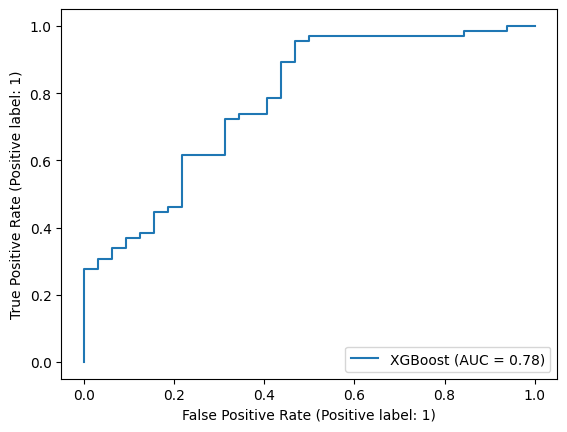

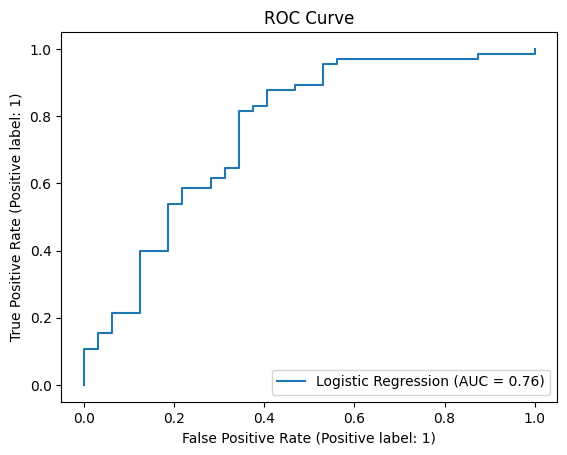

In [ ]:
# Plot ROC curves and calculate AUC
plt.figure()

for model_name, proba in models.items():
    auc = roc_auc_score(y_test, proba)
    print(f"{model_name} AUC: {auc:.4f}")
    RocCurveDisplay.from_predictions(y_test, proba, name=model_name)

plt.title('ROC Curve')
plt.show()

In [ ]:
# Conclusion
xgb_auc = roc_auc_score(y_test, xgb_proba)
logistic_auc = roc_auc_score(y_test, logistic_predictions_proba)

print("Conclusion:")
if xgb_auc > logistic_auc:
    print(f"XGBoost model performs better than logistic regression model with an AUC of {xgb_auc:.4f}")
elif xgb_auc < logistic_auc:
    print(f"Logistic regression model performs better than XGBoost model with an AUC of {logistic_auc:.4f}")
else:
    print(f"Both XGBoost and logistic regression models have the same AUC of {xgb_auc:.4f}")


Conclusion:
XGBoost model performs better than logistic regression model with an AUC of 0.7774
